In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Devkit

Please refer to [the OpenLane-V2 devkit](https://github.com/OpenDriveLab/OpenLane-V2/blob/master/docs/devkit.md) for a detailed description of the API.

In [2]:
root_path = '../data/OpenLane-V2'

## Preprocessing

Collect meta data of a collection of data and store it into a pickle file, where the collection can be user-defined by modifying the input data_dict. Note that for evaluation, we subsample the number of points of lane centerlines with an interval of 20. For training, the `point_interval` can be set to 1 to disable subsampling.

To preprocess the whole dataset, please refer to [preprocess](https://github.com/OpenDriveLab/OpenLane-V2/blob/master/data/README.md#preprocess).

In [3]:
from openlanev2.centerline.io import io
from openlanev2.lanesegment.preprocessing import collect

data_dict = io.json_load(f'{root_path}/data_dict_sample.json')
collect(root_path, data_dict, 'data_dict_sample_ls', point_interval=20)

collecting data_dict_sample_ls: 100%|███████████| 64/64 [00:00<00:00, 85.92it/s]


---

## Dataset

Load meta data from the generated pickle file.
A frame can be fetched by specifying the identifier `(split, segment_id, timestamp)` or giving the index of the data in the collection.

In [4]:
from openlanev2.lanesegment.dataset import Collection, Frame

collection = Collection(root_path, root_path, 'data_dict_sample_ls')
frame = collection.get_frame_via_identifier(('train', '00492', '315970276749927222'))

The pose of the ego vehicle can be obtained by `get_pose()`.

In [5]:
for k, v in frame.get_pose().items():
    print(k, '\n', v, '\n')

rotation 
 [[-0.03161852  0.99932457  0.01872611]
 [-0.99904989 -0.03103652 -0.0305949 ]
 [-0.02999304 -0.01967568  0.99935644]] 

translation 
 [6657.19639943 1842.86566032   59.89421563] 



Each frame contains multi-view images covering the whole horizontal FOV.

In [6]:
for k in frame.get_camera_list():
    print(k)

ring_front_center
ring_front_left
ring_front_right
ring_rear_left
ring_rear_right
ring_side_left
ring_side_right


For each image, we provide intrinsic and extrinsic matrices of the camera.

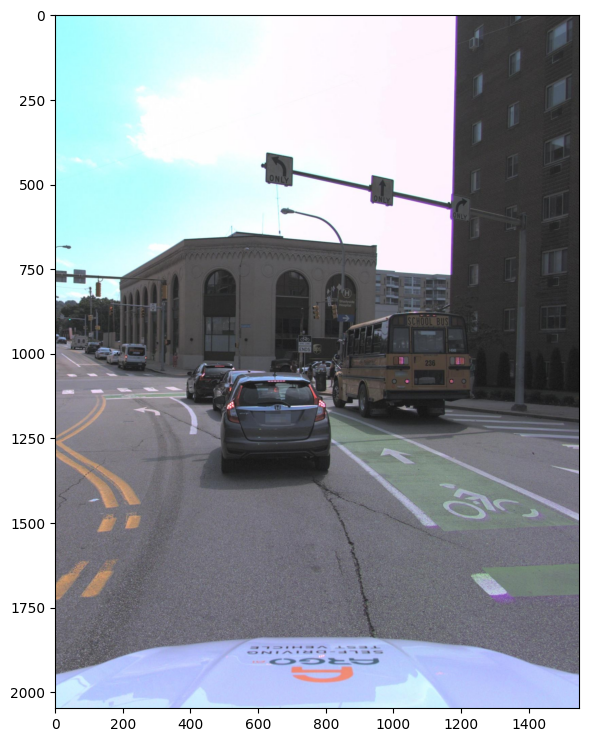

intrinsic - K 
 [[1.77753967e+03 0.00000000e+00 7.77762878e+02]
 [0.00000000e+00 1.77753967e+03 1.01631311e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

intrinsic - distortion 
 [-0.24479243 -0.19577468  0.30131747] 

extrinsic - rotation 
 [[-8.48589870e-04  1.00005773e-02  9.99949633e-01]
 [-9.99998983e-01 -1.15429954e-03 -8.37087508e-04]
 [ 1.14587004e-03 -9.99949327e-01  1.00015467e-02]] 

extrinsic - translation 
 [1.63315125 0.00800013 1.38385219] 



In [7]:
camera = frame.get_camera_list()[0]

image = frame.get_rgb_image(camera)

plt.figure(figsize=[16, 9])
plt.imshow(image)
plt.show()

meta = {
    'intrinsic': frame.get_intrinsic(camera),
    'extrinsic': frame.get_extrinsic(camera),
}
for key, value in meta.items():
    for k, v in value.items():
        print(key, '-', k, '\n', v, '\n')

Annotations of a frame can be loaded separately.

In [8]:
annotations = frame.get_annotations()
print(list(annotations.keys()))

for a, anno in zip(
    ['lane_segment', 'traffic_element', 'area', 'topology_lsls', 'topology_lste'], 
    [
        frame.get_annotations_lane_segments()[0],
        frame.get_annotations_traffic_elements()[0],
        frame.get_annotations_areas()[0],
        frame.get_annotations_topology_lsls(),
        frame.get_annotations_topology_lste(),
    ]):
    print(f'\n{a}:')
    if isinstance(anno, dict):
        for k, v in anno.items():
            print(k, v.shape) if isinstance(v, np.ndarray) else print(k, type(v))
    else:
        print('adjacent matrix', anno.shape)

['lane_segment', 'traffic_element', 'topology_lsls', 'topology_lste', 'area']

lane_segment:
id <class 'str'>
centerline (1, 3)
left_laneline (2, 3)
left_laneline_type <class 'int'>
right_laneline (2, 3)
right_laneline_type <class 'int'>
is_intersection_or_connector <class 'bool'>

traffic_element:
id <class 'str'>
category <class 'int'>
attribute <class 'int'>
points (2, 2)

area:
id: <class 'str'>
points (5, 3)
category <class 'int'>

topology_lsls:
adjacent matrix (76, 76)

topology_lste:
adjacent matrix (76, 11)


---

## Visualization

Preprocess the annotations for visualization.

In [9]:
from openlanev2.lanesegment.visualization import draw_annotation_bev, draw_annotation_pv, assign_attribute, assign_topology

annotations = assign_attribute(annotations)
annotations = assign_topology(annotations)

Visualize annotations in the bird's-eye view. `with_attribute` denotes that color is used to draw lane centerlines, which indicates the attribute of the lane centerline, or not.

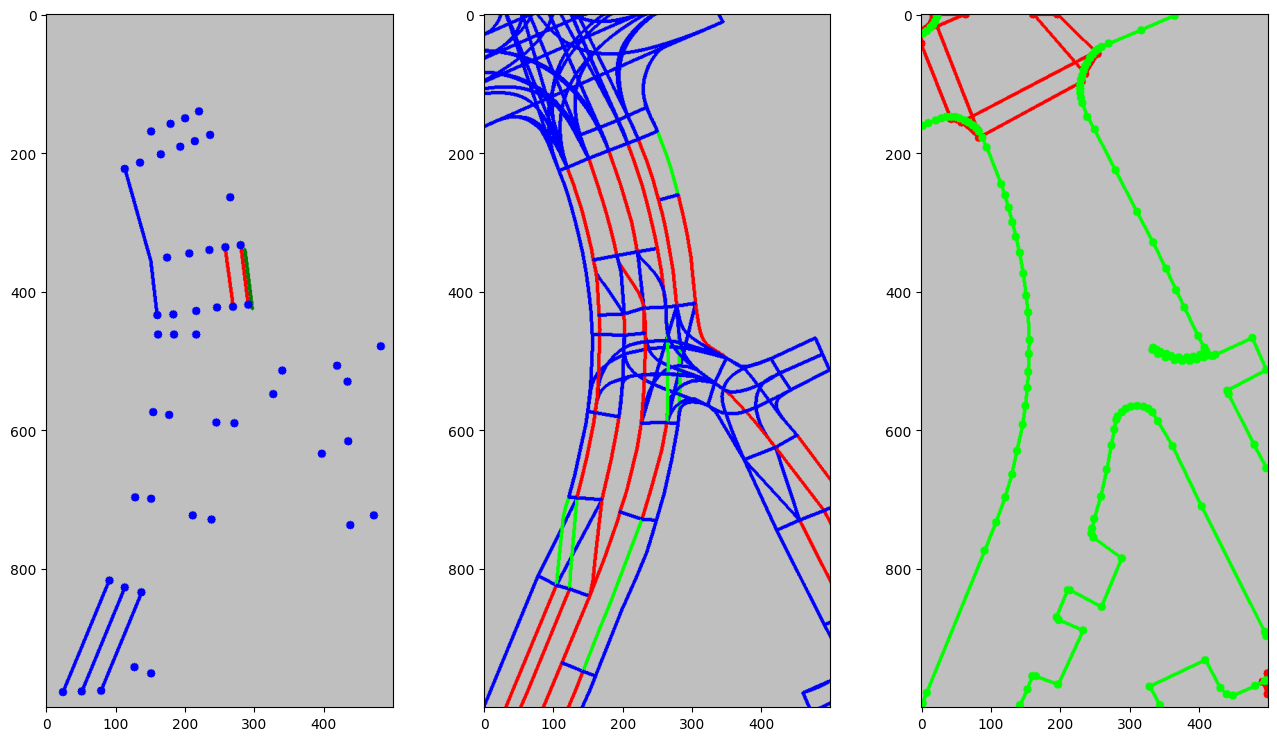

In [10]:
image_bev_centerline = draw_annotation_bev(
    annotations, 
    with_attribute=True,
    with_linetype=False,
    with_centerline=True, 
    with_laneline=False,
    with_area=False,
)
image_bev_laneline = draw_annotation_bev(
    annotations, 
    with_attribute=True,
    with_linetype=True,
    with_centerline=False, 
    with_laneline=True,
    with_area=False,
)
image_bev_area = draw_annotation_bev(
    annotations, 
    with_attribute=True,
    with_linetype=True,
    with_centerline=False, 
    with_laneline=False,
    with_area=True,
)

plt.figure(figsize=[16, 9])
plt.subplot(1, 3, 1).imshow(image_bev_centerline)
plt.subplot(1, 3, 2).imshow(image_bev_laneline)
plt.subplot(1, 3, 3).imshow(image_bev_area)
plt.show()

Visualize annotations in the perspective view. Note that as traffic elements are annotated in the front-view image, visualization for traffic elements and the topology is only valid in the front-view image.

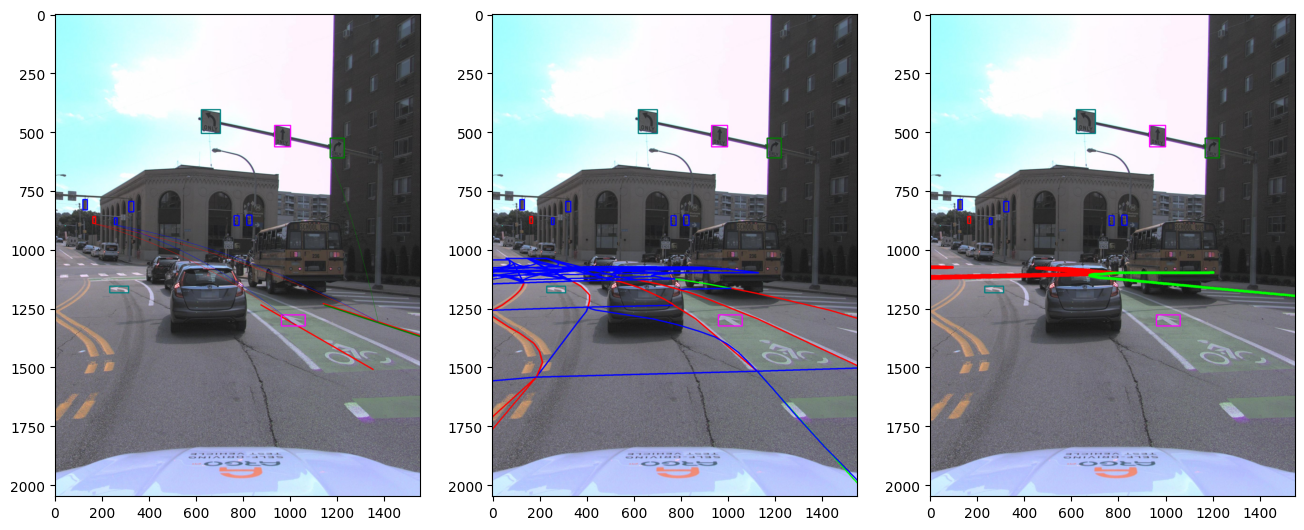

In [11]:
image_pv_centerline = draw_annotation_pv(
    camera, 
    image.copy(), 
    annotations,
    meta['intrinsic'],
    meta['extrinsic'],
    with_attribute=True,
    with_linetype=True,
    with_topology=True,
    with_centerline=True, 
    with_laneline=False,
    with_area=False,
)
image_pv_laneline = draw_annotation_pv(
    camera, 
    image.copy(), 
    annotations,
    meta['intrinsic'],
    meta['extrinsic'],
    with_attribute=False,
    with_linetype=True,
    with_topology=False,
    with_centerline=False, 
    with_laneline=True,
    with_area=False,
)
image_pv_area = draw_annotation_pv(
    camera, 
    image.copy(), 
    annotations,
    meta['intrinsic'],
    meta['extrinsic'],
    with_attribute=False,
    with_linetype=True,
    with_topology=False,
    with_centerline=False, 
    with_laneline=False,
    with_area=True,
)

plt.figure(figsize=[16, 9])
plt.subplot(1, 3, 1).imshow(image_pv_centerline)
plt.subplot(1, 3, 2).imshow(image_pv_laneline)
plt.subplot(1, 3, 3).imshow(image_pv_area)
plt.show()

---

## Evaluation

We provide tools for evaluation based on the generated pickle files.
The input can be a path to the pickle or a formatted dictionary.

In [12]:
from openlanev2.lanesegment.evaluation import evaluate
from openlanev2.utils import format_metric

format_metric(evaluate(ground_truth=f'{root_path}/data_dict_sample_ls.pkl', predictions=None))


Dummy evaluation on ground truth.



calculating distances:: 100%|███████████████████| 64/64 [00:20<00:00,  3.05it/s]


OpenLane-V2 Score - 1.0
    DET_l - 1.0
    DET_a - 1.0
    DET_t - 1.0
    TOP_ll - 1.0
    TOP_lt - 1.0


To construct results for evaluation, please follow the example below.

In [13]:
results = {
    'method': 'dummy',
    'e-mail': 'dummy@openlanev2',
    'institution / company': 'dummy',
    'results': {},
}
for key in collection.keys:
    results['results'][key] = {
        'predictions': {
            'lane_segment': [{
                'id': 20,
                'centerline': np.asarray([
                    [1, 2, 3],
                    [2, 3, 4],
                ]),
                'left_laneline': np.asarray([
                    [1, 2, 3],
                    [2, 3, 4],
                ]),
                'left_laneline_type': 0,
                'right_laneline': np.asarray([
                    [1, 2, 3],
                    [2, 3, 4],
                ]),
                'right_laneline_type': 0,
                'confidence': 0.6,
            }],
            'traffic_element': [{
                'id': i,
                'category': 0,
                'attribute': i,
                'points': np.asarray([
                    [1, 2],
                    [3, 4],
                ]),
                'confidence': 0.7,
            } for i in range(13)],
            'area': [{
                'id': 0,
                'category': 1,
                'points': np.asarray([
                    [1, 2, 3],
                    [2, 3, 4],
                ]),
                'confidence': 0.8,
            }],
            'topology_lsls': np.asarray([
                [0],
            ]),
            'topology_lste': np.asarray([
                [0.8 for _ in range(13)],
            ]),
        }
    }

results = evaluate(
    ground_truth=f'{root_path}/data_dict_sample_ls.pkl', 
    predictions=results,
)

calculating distances:: 100%|███████████████████| 64/64 [00:00<00:00, 92.43it/s]


---

# SD Map as Prior Expansion

In the [SD Map as Prior Expansion](https://github.com/OpenDriveLab/OpenLane-V2#sd-map-as-prior-), we includes SD maps as extra sensor input to offer preliminary knowledge. To collect the corresponding data, `with_sd_map=True` is included as an additional parameter.

In [14]:
data_dict = io.json_load(f'{root_path}/data_dict_sample.json')
collect(root_path, data_dict, 'data_dict_sample_ls_sd', point_interval=20, with_sd_map=True)

collection = Collection(root_path, root_path, 'data_dict_sample_ls_sd')
frame = collection.get_frame_via_identifier(('train', '00492', '315970276749927222'))

print(frame.get_sd_map()[0])

collecting data_dict_sample_ls_sd: 100%|████████| 64/64 [00:00<00:00, 82.84it/s]
/home/wanghuijie/miniconda3/envs/openlanev2/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[[45.909203 15.562097]
 [41.960938 25.      ]]


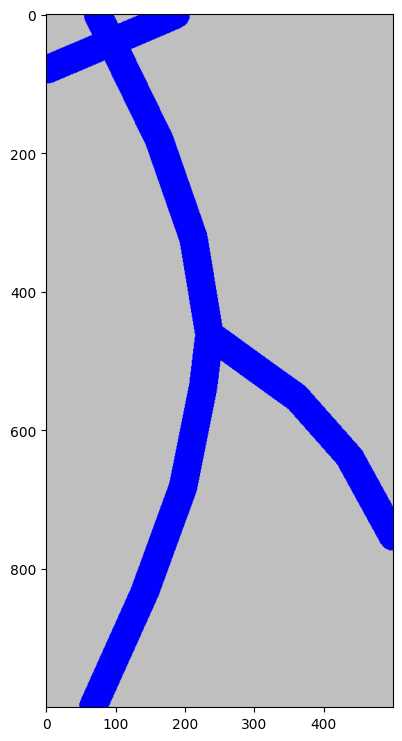

In [15]:
from openlanev2.lanesegment.visualization import draw_sd_map

image_bev = draw_sd_map(
    frame.get_sd_map(), 
)

plt.figure(figsize=[16, 9])
plt.imshow(image_bev)
plt.show()